In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns

1. Цель теста
Проверить повышает ли новая верся конверсию пользователей по сравнению с текущей

2. Описание эксперимента
Период проведения теста: с 2017-03-15 по 2017-04-30
Количество участников: 50500 (контрольная — 26968, тестовая — 23532)


3. Метрики и методика анализа
Основная метрика: конверсия
Статистические методы: z-тест на конверсии, логистическая регрессия с учётом сегментов


# загрузка, очистка, объединение, извлечение учавствующих в тесте

In [3]:
df_final_demo = pd.read_csv('df_final_demo.txt')
df_final_exp = pd.read_csv('df_final_experiment_clients.txt')
df_final_web_pt_1 = pd.read_csv('df_final_web_data_pt_1.txt')
df_final_web_pt_2 = pd.read_csv('df_final_web_data_pt_2.txt')

In [4]:
df_final_web_total = pd.concat([df_final_web_pt_1,df_final_web_pt_2], ignore_index=True)

In [5]:
df_merged = (df_final_web_total.merge(df_final_exp, on = 'client_id', how = 'left')
            .merge(df_final_demo, on = 'client_id', how = 'left'))

In [6]:
df_merged.drop_duplicates(inplace=True)
df_merged.reset_index(inplace=True, drop = True)

In [7]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 744641 entries, 0 to 744640
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         744641 non-null  int64  
 1   visitor_id        744641 non-null  object 
 2   visit_id          744641 non-null  object 
 3   process_step      744641 non-null  object 
 4   date_time         744641 non-null  object 
 5   Variation         317235 non-null  object 
 6   clnt_tenure_yr    443784 non-null  float64
 7   clnt_tenure_mnth  443784 non-null  float64
 8   clnt_age          443772 non-null  float64
 9   gendr             443784 non-null  object 
 10  num_accts         443784 non-null  float64
 11  bal               443784 non-null  float64
 12  calls_6_mnth      443784 non-null  float64
 13  logons_6_mnth     443784 non-null  float64
dtypes: float64(7), int64(1), object(6)
memory usage: 79.5+ MB


In [8]:
df_converted = (df_merged.groupby('client_id')['process_step']
                .apply(lambda x: 'confirm' in x.values)
               .reset_index(name = 'converted'))

In [9]:
df_client_tc = df_merged[['client_id', 'Variation']].dropna().drop_duplicates()

In [10]:
df_clean = df_converted.merge(df_client_tc, on = 'client_id', how = 'right').reset_index(drop = True)
df_clean_full = (df_merged[df_merged['client_id'].isin(df_clean.client_id)]
                 [["client_id", "Variation", "clnt_age", 
                   "gendr", "clnt_tenure_yr", "num_accts", 
                   "bal", "calls_6_mnth", "logons_6_mnth"]]
                .drop_duplicates()
                .reset_index(drop = True))

In [11]:
df_clean_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50500 entries, 0 to 50499
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   client_id       50500 non-null  int64  
 1   Variation       50500 non-null  object 
 2   clnt_age        50487 non-null  float64
 3   gendr           50488 non-null  object 
 4   clnt_tenure_yr  50488 non-null  float64
 5   num_accts       50488 non-null  float64
 6   bal             50488 non-null  float64
 7   calls_6_mnth    50488 non-null  float64
 8   logons_6_mnth   50488 non-null  float64
dtypes: float64(6), int64(1), object(2)
memory usage: 3.5+ MB


In [12]:
df_clean_full[df_clean_full.clnt_age.isna()]

,client_id,Variation,clnt_age,gendr,clnt_tenure_yr,num_accts,bal,calls_6_mnth,logons_6_mnth
4118,8191345,Control,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5677,5144725,Test,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7093,7616759,Control,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14922,2222915,Test,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15455,5277910,Test,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18863,8412164,Test,NaN,NaN,NaN,NaN,NaN,NaN,NaN
28815,355337,Control,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30661,4666211,Control,NaN,F,8.0,2.0,42550.55,4.0,7.0
30701,1227228,Test,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38146,1037867,Test,NaN,NaN,NaN,NaN,NaN,NaN,NaN


~ 50/50 test/control все пропущено. удаляем

In [13]:
df_clean_full.dropna(subset=['clnt_age'], inplace=True)
df_clean_full.reset_index(drop=True, inplace=True)

In [14]:
df_clean_full.describe()

,client_id,clnt_age,clnt_tenure_yr,num_accts,bal,calls_6_mnth,logons_6_mnth
count,5.048700e+04,50487.000000,50487.000000,50487.000000,5.048700e+04,50487.000000,50487.000000
mean,5.006180e+06,47.319795,12.031810,2.254580,1.495168e+05,3.093272,6.131856
std,2.877445e+06,15.518616,6.860326,0.533675,3.020390e+05,2.188009,2.175441
min,5.550000e+02,17.000000,2.000000,1.000000,2.378944e+04,0.000000,3.000000
25%,2.515688e+06,33.500000,6.000000,2.000000,3.987718e+04,1.000000,4.000000
50%,5.025043e+06,48.000000,11.000000,2.000000,6.573433e+04,3.000000,6.000000
75%,7.477922e+06,59.500000,16.000000,2.000000,1.399583e+05,5.000000,8.000000
max,9.999832e+06,96.000000,55.000000,7.000000,1.632004e+07,6.000000,9.000000


In [15]:
df_clean_full.gendr.value_counts()

gendr
U    17280
M    16947
F    16258
X        2
Name: count, dtype: int64

In [16]:
df_clean_full = df_clean_full.query('gendr != "X"').reset_index(drop = True)
df_clean = df_clean[df_clean.client_id.isin(df_clean_full.client_id)].reset_index(drop= True)

# сравнение объема выборок, распределений

In [18]:
df_clean.Variation.value_counts(normalize = True)

Variation
Test       0.534
Control    0.466
Name: proportion, dtype: float64

! небольшое расхождение в количестве участников

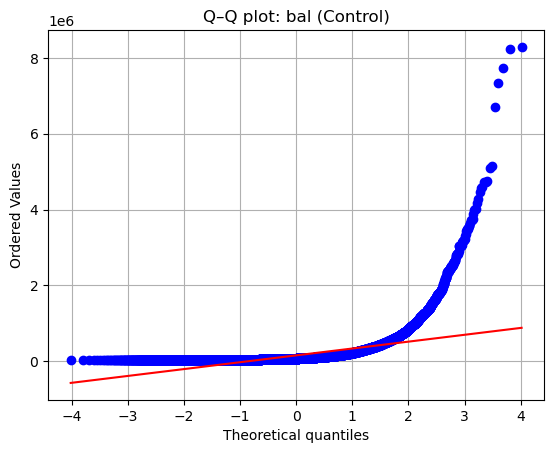

In [19]:
stats.probplot(df_clean_full.query('Variation == "Control"').bal, dist="norm", plot=plt)
plt.title(f"Q–Q plot: {'bal'} ({'Control'})")
plt.grid(True)
plt.show()


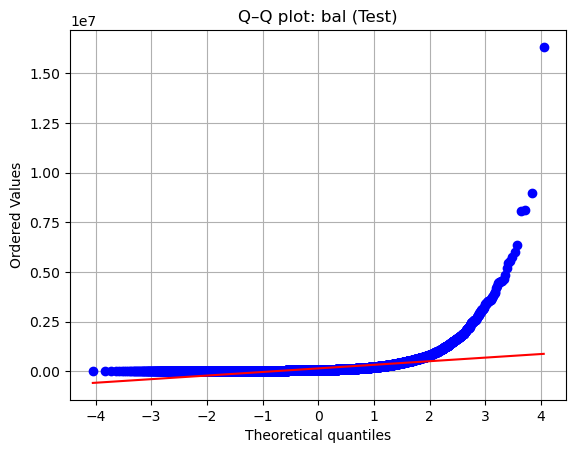

In [20]:
stats.probplot(df_clean_full.query('Variation != "Control"').bal, dist="norm", plot=plt)
plt.title(f"Q–Q plot: {'bal'} ({'Test'})")
plt.grid(True)
plt.show()

 РАспределение в bal не нормальное - это естественно для сумм на счету.

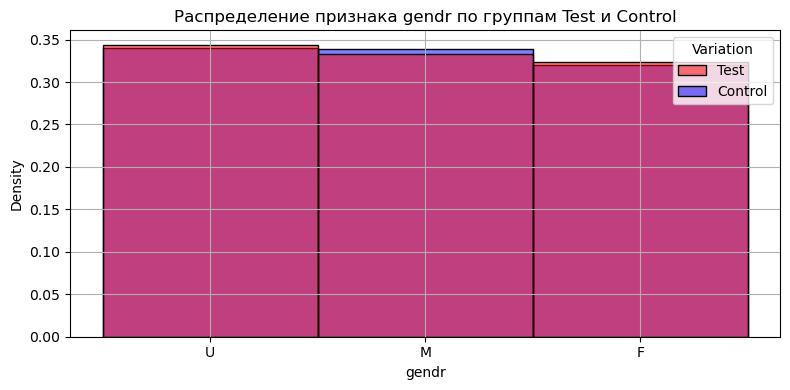

In [21]:
for i in [ 'gendr']:
    plt.figure(figsize=(8, 4))
    
    sns.histplot(
        data=df_clean_full[df_clean_full['Variation'].isin(['Test', 'Control'])],
        x=i,
        hue='Variation',
        bins=30,
        stat='density',
        element='bars',  
        common_norm=False,
        palette={'Test': 'red', 'Control': 'blue'},
        alpha=0.5
    )
    
    plt.title(f'Распределение признака {i} по группам Test и Control')
    plt.xlabel(i)
    plt.ylabel("Density")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [22]:
df_clean_full


,client_id,Variation,clnt_age,gendr,clnt_tenure_yr,num_accts,bal,calls_6_mnth,logons_6_mnth
0,9988021,Test,79.0,U,5.0,2.0,189023.86,1.0,4.0
1,8320017,Test,34.5,M,22.0,2.0,36001.90,5.0,8.0
2,4033851,Control,63.5,M,12.0,2.0,142642.26,5.0,8.0
3,1982004,Test,44.5,U,6.0,2.0,30231.76,1.0,4.0
4,9294070,Control,29.0,U,5.0,2.0,34254.54,0.0,3.0
...,...,...,...,...,...,...,...,...,...
50480,1129748,Control,58.0,M,12.0,2.0,46719.60,6.0,9.0
50481,8756202,Test,49.0,M,19.0,2.0,113455.08,5.0,8.0
50482,433098,Control,25.0,U,6.0,2.0,34419.62,2.0,5.0
50483,1574008,Test,55.0,U,10.0,2.0,153238.83,3.0,6.0


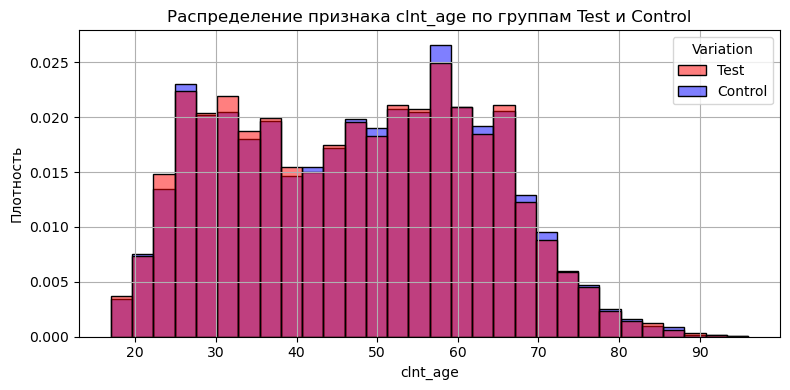

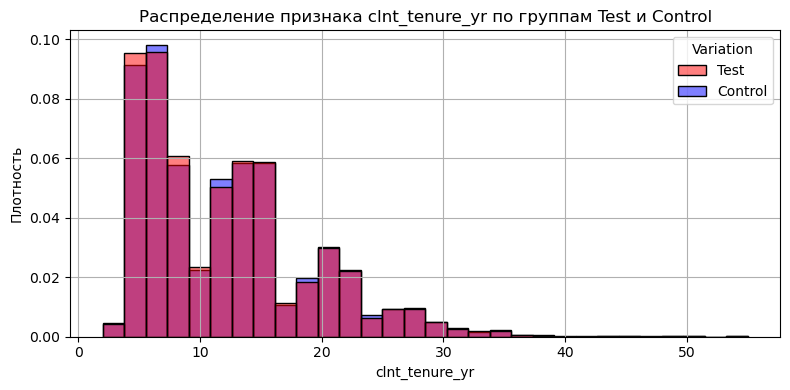

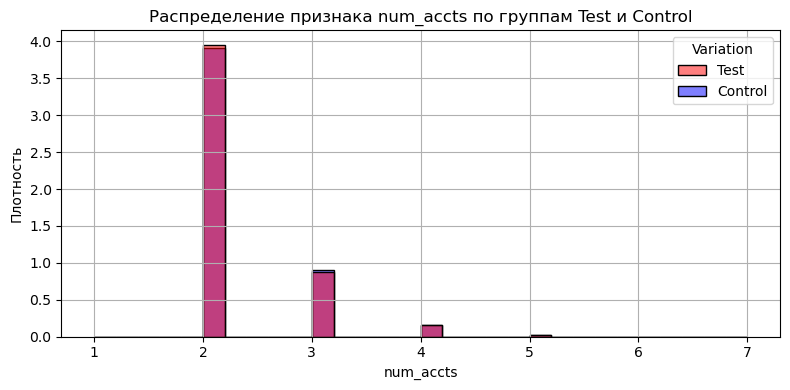

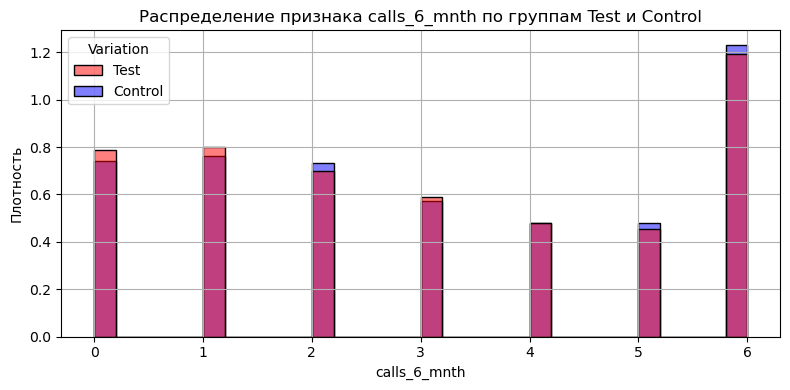

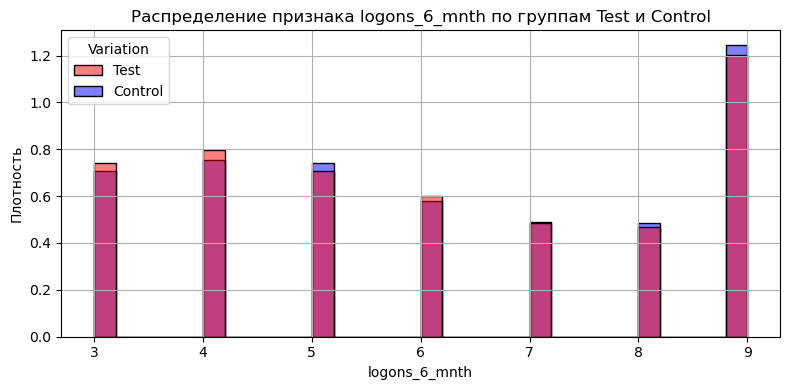

In [23]:
numeric_columns = ['clnt_age', 'clnt_tenure_yr', 'num_accts', 'calls_6_mnth', 'logons_6_mnth']

for i in numeric_columns:
    plt.figure(figsize=(8, 4))

    sns.histplot(
        data=df_clean_full[df_clean_full['Variation'].isin(['Test', 'Control'])],
        x=i,
        hue='Variation',
        bins=30,
        stat='density',
        common_norm=False,
        palette={'Test': 'red', 'Control': 'blue'},
        alpha=0.5,
        element='bars'
    )

    plt.title(f'Распределение признака {i} по группам Test и Control')
    plt.xlabel(i)
    plt.ylabel("Плотность")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

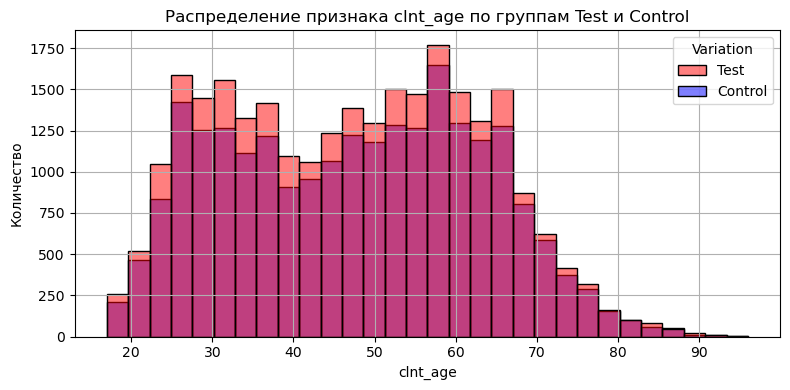

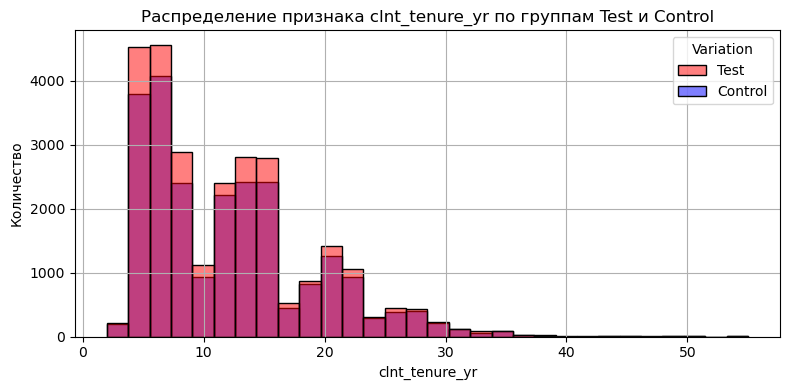

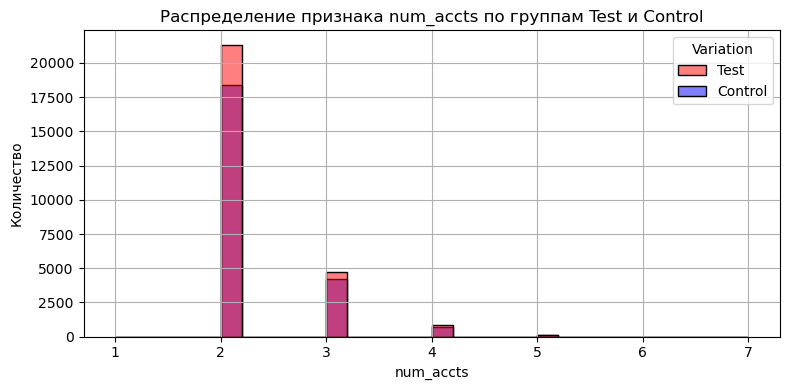

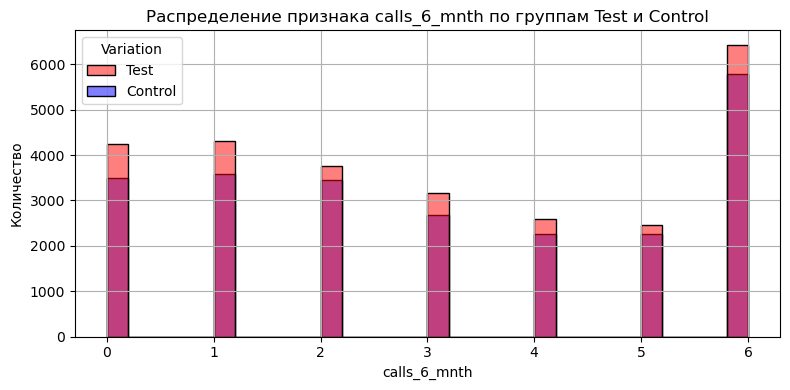

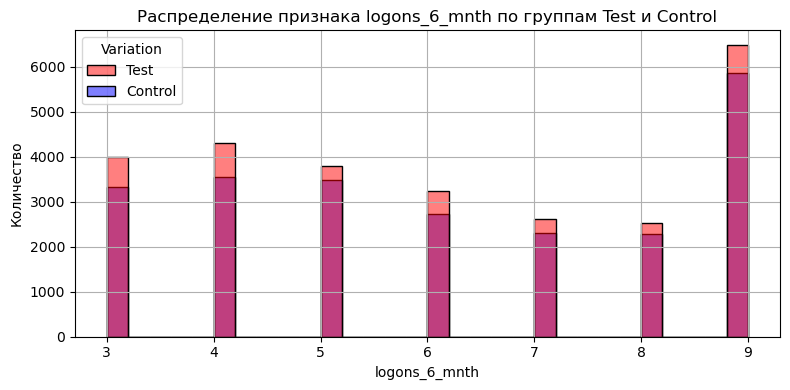

In [24]:
numeric_columns_disc = ['clnt_age', 'clnt_tenure_yr', 'num_accts', 'calls_6_mnth', 'logons_6_mnth']

for i in numeric_columns_disc:
    plt.figure(figsize=(8, 4))

    sns.histplot(
        data=df_clean_full[df_clean_full['Variation'].isin(['Test', 'Control'])],
        x=i,
        hue='Variation',
        bins=30,
        stat='count',
        common_norm=False,
        palette={'Test': 'red', 'Control': 'blue'},
        alpha=0.5,
        element='bars'
    )

    plt.title(f'Распределение признака {i} по группам Test и Control')
    plt.xlabel(i)
    plt.ylabel("Количество")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Очень похожая плотнотсь, количество в тестовых больше что нормально, так как из больше в выборке.
распределения не нормальны у всех признаков

## проверяем распределение 

In [26]:
contingency = pd.crosstab(df_clean_full['Variation'], df_clean_full['gendr'])
chi2, p_chi2, _, _ = stats.chi2_contingency(contingency)

In [27]:
f'chi2 {chi2}, p_chi2 {p_chi2}'

'chi2 1.887142620657543, p_chi2 0.3892352702565598'

In [28]:
numeric_columns = ['clnt_age', 'clnt_tenure_yr', 'bal', 'num_accts', 'calls_6_mnth', 'logons_6_mnth']

for i in numeric_columns:
    test_col = df_clean_full.query('Variation == "Test"')[i]
    control_col = df_clean_full.query('Variation == "Control"')[i]
    median_test = test_col.median()
    median_control = control_col.median()
    stat, p_val = stats.mannwhitneyu(test_col, control_col, alternative='two-sided')
    print(f'{i} M-W p_val {p_val: .5f}       median_test {median_test} median_control {median_control}')

clnt_age M-W p_val  0.01497       median_test 47.5 median_control 48.5
clnt_tenure_yr M-W p_val  0.08667       median_test 11.0 median_control 11.0
bal M-W p_val  0.15104       median_test 65468.67 median_control 66031.45
num_accts M-W p_val  0.03032       median_test 2.0 median_control 2.0
calls_6_mnth M-W p_val  0.00050       median_test 3.0 median_control 3.0
logons_6_mnth M-W p_val  0.00084       median_test 6.0 median_control 6.0


clnt_age num_accts calls_6_mnth logons_6_mnth - есть различия !

# AA test

In [30]:
df_control = df_clean_full.query('Variation == "Control"').copy()

np.random.seed(1)
df_control['AA_group'] = np.random.choice(['AA_1', 'AA_2'], size = len(df_control))
df_control = df_control.merge(df_clean, on = ['client_id', 'Variation'])

In [31]:
df_control.head(3)

,client_id,Variation,clnt_age,gendr,clnt_tenure_yr,num_accts,bal,calls_6_mnth,logons_6_mnth,AA_group,converted
0,4033851,Control,63.5,M,12.0,2.0,142642.26,5.0,8.0,AA_2,True
1,9294070,Control,29.0,U,5.0,2.0,34254.54,0.0,3.0,AA_2,False
2,6651403,Control,56.5,M,13.0,2.0,324712.88,4.0,7.0,AA_1,True


In [32]:
contingency = pd.crosstab(df_control['AA_group'], df_control['gendr'])
chi2, p_chi2, _, _ = stats.chi2_contingency(contingency)

In [33]:
f'chi2 {chi2}, p_chi2 {p_chi2}'

'chi2 0.44813700703082904, p_chi2 0.7992603803481797'

In [34]:
for col in numeric_columns:
    group1 = df_control[df_control['AA_group'] == 'AA_1'][col]
    group2 = df_control[df_control['AA_group'] == 'AA_2'][col]
    stat, pval = stats.mannwhitneyu(group1, group2, alternative='two-sided')
    print(f"{col}: p-value = {pval:.4f}")

clnt_age: p-value = 0.7684
clnt_tenure_yr: p-value = 0.8015
bal: p-value = 0.5116
num_accts: p-value = 0.4240
calls_6_mnth: p-value = 0.3634
logons_6_mnth: p-value = 0.4316


In [35]:
from statsmodels.stats.proportion import proportions_ztest
converted_1 = df_control[df_control['AA_group'] == 'AA_1']['converted'].sum()
n1 = df_control[df_control['AA_group'] == 'AA_1'].shape[0]

converted_2 = df_control[df_control['AA_group'] == 'AA_2']['converted'].sum()
n2 = df_control[df_control['AA_group'] == 'AA_2'].shape[0]

count = np.array([converted_1, converted_2])
nobs = np.array([n1, n2])

stat, pval = proportions_ztest(count, nobs)
print(f"A/A-тест по конверсии: p-value = {pval:.5f}")

A/A-тест по конверсии: p-value = 0.75208


## проверка на количестве случайных выборок

In [37]:
result = []
result_x = []
result_n = {}
for _ in range(100):
    df_control = df_clean_full.query('Variation == "Control"').copy()
    df_control['AA_group'] = np.random.choice(['AA_1', 'AA_2'], size = len(df_control))
    df_control = df_control.merge(df_clean, on = ['client_id', 'Variation'])
    contingency = pd.crosstab(df_control['AA_group'], df_control['gendr'])
    chi2, p_chi2, _, _ = stats.chi2_contingency(contingency)
    result_x.append(p_chi2)
    for col in numeric_columns:
        group1 = df_control[df_control['AA_group'] == 'AA_1'][col]
        group2 = df_control[df_control['AA_group'] == 'AA_2'][col]
        stat, pval = stats.mannwhitneyu(group1, group2, alternative='two-sided')
        if col in result_n:
            result_n[col].append(pval)
        else:
            result_n[col] = []
            result_n[col].append(pval)
    converted_1 = df_control[df_control['AA_group'] == 'AA_1']['converted'].sum()
    n1 = df_control[df_control['AA_group'] == 'AA_1'].shape[0]
    
    converted_2 = df_control[df_control['AA_group'] == 'AA_2']['converted'].sum()
    n2 = df_control[df_control['AA_group'] == 'AA_2'].shape[0]
    
    count = np.array([converted_1, converted_2])
    nobs = np.array([n1, n2])
    
    stat, pval = proportions_ztest(count, nobs)
    result.append(pval)

In [38]:
sum([i > 0.05 for i in result])/len(result)

0.95

In [39]:
sum([i > 0.05 for i in result_x])/len(result_x)

0.95

In [40]:
for i in result_n:
    print(i, end = ' ')
    print(sum([i > 0.05 for i in result_n[i]])/len(result_n[i]))

clnt_age 0.97
clnt_tenure_yr 0.95
bal 0.94
num_accts 0.96
calls_6_mnth 0.95
logons_6_mnth 0.94


Можно оставить текущую реализацию сплиттера, так как она не даёт перекосов. A/A-проверка пройдена успешно, можно переходить к анализу A/B.

# AB test

In [47]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

conversion_stats = df_clean.groupby('Variation')['converted'].agg(['sum', 'count'])
conversion_stats['conversion_rate'] = conversion_stats['sum'] / conversion_stats['count']

print("Conversion rates:")
print(conversion_stats[['conversion_rate']])
print()


confint_low = []
confint_upp = []

for idx, row in conversion_stats.iterrows():
    low, upp = proportion_confint(count=row['sum'], nobs=row['count'], alpha=0.05, method='wilson')
    confint_low.append(low)
    confint_upp.append(upp)

conversion_stats['ci_lower'] = confint_low
conversion_stats['ci_upper'] = confint_upp

print("Conversion rates with 95% Wilson confidence intervals:")
print(conversion_stats[['conversion_rate', 'ci_lower', 'ci_upper']])
print()
count = conversion_stats['sum'].values
nobs = conversion_stats['count'].values

stat, pval = proportions_ztest(count, nobs)
print(f"Z-test statistic: {stat:.4f}")
print(f"P-value: {pval:.5f}")


Conversion rates:
           conversion_rate
Variation                 
Control           0.655785
Test              0.692978

Conversion rates with 95% Wilson confidence intervals:
           conversion_rate  ci_lower  ci_upper
Variation                                     
Control           0.655785  0.649689  0.661830
Test              0.692978  0.687445  0.698456

Z-test statistic: -8.9051
P-value: 0.00000


значимые отличия, тестовая группа покзывает конверсию лучше

так как при проверке были признаки показывающие различия в тестовой и контроьной группе проведем логистическую регрессию

In [49]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [79]:
df_clean_full

,client_id,Variation,clnt_age,gendr,clnt_tenure_yr,num_accts,bal,calls_6_mnth,logons_6_mnth
0,9988021,Test,79.0,U,5.0,2.0,189023.86,1.0,4.0
1,8320017,Test,34.5,M,22.0,2.0,36001.90,5.0,8.0
2,4033851,Control,63.5,M,12.0,2.0,142642.26,5.0,8.0
3,1982004,Test,44.5,U,6.0,2.0,30231.76,1.0,4.0
4,9294070,Control,29.0,U,5.0,2.0,34254.54,0.0,3.0
...,...,...,...,...,...,...,...,...,...
50480,1129748,Control,58.0,M,12.0,2.0,46719.60,6.0,9.0
50481,8756202,Test,49.0,M,19.0,2.0,113455.08,5.0,8.0
50482,433098,Control,25.0,U,6.0,2.0,34419.62,2.0,5.0
50483,1574008,Test,55.0,U,10.0,2.0,153238.83,3.0,6.0


In [81]:
df_for_log = df_clean_full.merge(df_clean, on = ['client_id', 'Variation'])
df_for_log.converted = df_for_log.converted.astype(int)
df_for_log.Variation = df_for_log.Variation.apply(lambda x: 1 if x == 'Test' else 0)

In [83]:
df_for_log


,client_id,Variation,clnt_age,gendr,clnt_tenure_yr,num_accts,bal,calls_6_mnth,logons_6_mnth,converted
0,9988021,1,79.0,U,5.0,2.0,189023.86,1.0,4.0,0
1,8320017,1,34.5,M,22.0,2.0,36001.90,5.0,8.0,1
2,4033851,0,63.5,M,12.0,2.0,142642.26,5.0,8.0,1
3,1982004,1,44.5,U,6.0,2.0,30231.76,1.0,4.0,1
4,9294070,0,29.0,U,5.0,2.0,34254.54,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...
50480,1129748,0,58.0,M,12.0,2.0,46719.60,6.0,9.0,1
50481,8756202,1,49.0,M,19.0,2.0,113455.08,5.0,8.0,0
50482,433098,0,25.0,U,6.0,2.0,34419.62,2.0,5.0,1
50483,1574008,1,55.0,U,10.0,2.0,153238.83,3.0,6.0,1


In [85]:
formula = 'converted ~ Variation + clnt_age + gendr + num_accts + bal + calls_6_mnth + logons_6_mnth'

In [89]:
model = smf.logit(formula = formula, data = df_for_log).fit()
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.625318
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:                50485
Model:                          Logit   Df Residuals:                    50476
Method:                           MLE   Df Model:                            8
Date:                Tue, 08 Jul 2025   Pseudo R-squ.:                0.007601
Time:                        09:13:54   Log-Likelihood:                -31569.
converged:                       True   LL-Null:                       -31811.
Covariance Type:            nonrobust   LLR p-value:                 2.348e-99
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         0.8999      0.133      6.746      0.000       0.638       1.161
gendr[T.M]        0.

clnt_tenure_yr == p_val 0.418, a без него bal < 0.05 на границе, но так как он различается в выборке оставляем. Где то есть взаимосвязь
Variation все еще стат значим, и соотвественно дает ~ 18.8 % увесличения шансов конверсии

проверим в каких сегментах есть изменения или ни в каких

In [93]:
tmp = df_for_log.copy()

In [95]:
tmp['gendr_M'] = (tmp['gendr'] == 'M').astype(int)
tmp['Interaction'] = tmp['Variation'] * tmp['gendr_M']

formula = 'converted ~ Variation + gendr_M + Interaction + clnt_age + num_accts + calls_6_mnth + logons_6_mnth + clnt_tenure_yr'
model_interaction = smf.logit(formula=formula, data=tmp).fit()

print(model_interaction.summary())

Optimization terminated successfully.
         Current function value: 0.625482
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:                50485
Model:                          Logit   Df Residuals:                    50476
Method:                           MLE   Df Model:                            8
Date:                Tue, 08 Jul 2025   Pseudo R-squ.:                0.007341
Time:                        09:15:38   Log-Likelihood:                -31577.
converged:                       True   LL-Null:                       -31811.
Covariance Type:            nonrobust   LLR p-value:                 8.250e-96
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.9462      0.130      7.259      0.000       0.691       1.202
Variation        

In [97]:
tmp["Interaction"] = tmp["Variation"] * tmp["clnt_age"]

formula = 'converted ~ Variation + clnt_age + Interaction + gendr_M + num_accts + calls_6_mnth + logons_6_mnth + clnt_tenure_yr'
model_age = smf.logit(formula=formula, data=tmp).fit()
print(model_age.summary())


Optimization terminated successfully.
         Current function value: 0.625489
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:                50485
Model:                          Logit   Df Residuals:                    50476
Method:                           MLE   Df Model:                            8
Date:                Tue, 08 Jul 2025   Pseudo R-squ.:                0.007330
Time:                        09:15:39   Log-Likelihood:                -31578.
converged:                       True   LL-Null:                       -31811.
Covariance Type:            nonrobust   LLR p-value:                 1.146e-95
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.9148      0.134      6.828      0.000       0.652       1.177
Variation        

In [99]:
tmp["Interaction"] = tmp["Variation"] * tmp["logons_6_mnth"]

formula = 'converted ~ Variation + logons_6_mnth + Interaction + gendr_M + clnt_age + num_accts + calls_6_mnth + clnt_tenure_yr'
model_logons = smf.logit(formula=formula, data=tmp).fit()
print(model_logons.summary())


Optimization terminated successfully.
         Current function value: 0.625479
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:                50485
Model:                          Logit   Df Residuals:                    50476
Method:                           MLE   Df Model:                            8
Date:                Tue, 08 Jul 2025   Pseudo R-squ.:                0.007346
Time:                        09:15:39   Log-Likelihood:                -31577.
converged:                       True   LL-Null:                       -31811.
Covariance Type:            nonrobust   LLR p-value:                 6.928e-96
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.9749      0.133      7.321      0.000       0.714       1.236
Variation        

In [101]:
tmp["Interaction"] = tmp["Variation"] * tmp["calls_6_mnth"]

formula = 'converted ~ Variation + calls_6_mnth + Interaction + gendr_M + clnt_age + num_accts + logons_6_mnth + clnt_tenure_yr'
model_calls = smf.logit(formula=formula, data=tmp).fit()
print(model_calls.summary())


Optimization terminated successfully.
         Current function value: 0.625476
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:                50485
Model:                          Logit   Df Residuals:                    50476
Method:                           MLE   Df Model:                            8
Date:                Tue, 08 Jul 2025   Pseudo R-squ.:                0.007350
Time:                        09:15:40   Log-Likelihood:                -31577.
converged:                       True   LL-Null:                       -31811.
Covariance Type:            nonrobust   LLR p-value:                 6.153e-96
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.9567      0.131      7.313      0.000       0.700       1.213
Variation        

In [103]:
tmp["Interaction"] = tmp["Variation"] * tmp["num_accts"]

formula = 'converted ~ Variation + num_accts + Interaction + gendr_M + clnt_age + calls_6_mnth + logons_6_mnth + clnt_tenure_yr'
model_accts = smf.logit(formula=formula, data=tmp).fit()
print(model_accts.summary())


Optimization terminated successfully.
         Current function value: 0.625494
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:                50485
Model:                          Logit   Df Residuals:                    50476
Method:                           MLE   Df Model:                            8
Date:                Tue, 08 Jul 2025   Pseudo R-squ.:                0.007322
Time:                        09:15:40   Log-Likelihood:                -31578.
converged:                       True   LL-Null:                       -31811.
Covariance Type:            nonrobust   LLR p-value:                 1.468e-95
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.9532      0.137      6.948      0.000       0.684       1.222
Variation        

In [105]:
tmp["Interaction"] = tmp["Variation"] * tmp["clnt_tenure_yr"]

formula = 'converted ~ Variation + clnt_tenure_yr + Interaction + gendr_M + clnt_age + num_accts + calls_6_mnth + logons_6_mnth'
model_tenure = smf.logit(formula=formula, data=tmp).fit()
print(model_tenure.summary())


Optimization terminated successfully.
         Current function value: 0.625495
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:                50485
Model:                          Logit   Df Residuals:                    50476
Method:                           MLE   Df Model:                            8
Date:                Tue, 08 Jul 2025   Pseudo R-squ.:                0.007321
Time:                        09:15:40   Log-Likelihood:                -31578.
converged:                       True   LL-Null:                       -31811.
Covariance Type:            nonrobust   LLR p-value:                 1.542e-95
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.9402      0.131      7.160      0.000       0.683       1.198
Variation        

Во всех протестированных сегментах нет статистически значимого взаимодействия с тестом.

# вывод

Вывод - Тестовая группа показала значимо более высокую конверсию, что имеет практическую ценность — прирост может привести к значительному росту прибыли при масштабировании.
Частота звонков и логинов незначительно снизилась в тесте, что может говорить о более быстрой ориентации в интерфейсе (или снижении нужды в поддержке)
Баланс и кол-во аккаунтов практически не изменились — эксперимент не повлиял на эти параметры
Несбалансированная демография: хотя группы рандомизированы, возможна небольшая разница в возрасте/поле. Это может влиять на конверсию
U-пол в данных: присутствует неопределённый пол (U), который трудно интерпретировать.

Рекомендации - Масштабировать решение на всю базу: конверсия растёт, побочных эффектов не обнаружено.
Необходим анализ по сегментам
Падение звонков/логинов может быть как позитивным (интуитивный интерфейс), так и негативным (меньше интереса).